# Predicción de incendios en la Patgaonia Andina.

**Autor:** Claudio Ezequiel Villagra Turco  
**Institución:** Universidad Nacional Guillermo Brown (UNaB)  
**Fecha:** Q4 2025  
**Correo electrónico:** ezequiel26.92@gmail.com 

---

## Resumen



---

## 1. Introducción

### 1.1. Contexto y Justificación
Por medio de esta investigación se busca abordar el fenómeno de incendios forestales en la Patagonia Andina a partir de un enfoque basado en la recopilación de datos. A continuación, se establecen los objetivos que darán lugar al desarrollo del trabajo, orientados tanto a la comprensión de los factores asociados a la aparición de focos de calor como al diseño de herramientas que permitan su detección y predicción.


### 1.2. Objetivos
#### 1.2.1. Objetivo General
Estudiar y comprender los incendios forestales de la Patagonia Andina que tienen lugar durante epocas de verano analizando los factores determinantes, evaluando su relación con la ocurrencia de incendios y explorar su potencial en la construcción de modelos predictivos.

#### 1.2.2. Objetivos Específicos
1. Recopilar y sistematizar la información necesaria y disponible para el desarrollo del proyecto, incluyendo datos satelitales, climatológicos y ambientales.
2. Realizar un análisis exploratorio de los datos recopilados para identificar patrones y correlaciones entre las variables estudiadas y la ocurrencia de incendios.
3. Implementar modelos de Machine Learning que permitan identificar focos activos y predecir la probabilidad de nuevos focos en una región específica.
4. Evaluar la efectividad de los modelos desarrollados mediante la comparación de sus predicciones con datos históricos de incendios.


## 2. Preparación


### 2.1 - Configuración de entorno.

In [1]:
import os
import sys
import pandas as pd
import logging

sys.path.append('../scripts')

from project_config import ProjectConfig as cfg


### 2.2 - Utilidades.



#### 2.2.1 - Funciones de conversión.

In [7]:
# Función que permite pasar grados Kelvin a Celsius.
def kelvin_to_celsius(kelvin) :
    return kelvin - 273.15

#### 2.2.2 - Mapa de focos de calor.

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point, box

def detection_map(processed_data) : 
    # Crear GeoDataFrame con puntos
    geometry = [Point(xy) for xy in zip(processed_data.longitude, processed_data.latitude)]
    gdf = gpd.GeoDataFrame(processed_data, geometry=geometry, crs="EPSG:4326")

    # Pasar a Web Mercator para usar con contextily
    gdf_web = gdf.to_crs(epsg=3857)

    # Construir polígono del bbox
    bbox_poly = box(*cfg.BBOX)  # mismo que pasaste
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_poly], crs="EPSG:4326").to_crs(epsg=3857)

    # Figura
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Gráfico de líneas semanal
    weekly_counts = processed_data.set_index("acq_datetime").resample("W").size()

    weekly_counts.plot(
        ax=ax1, 
        kind="line", 
        marker="o", 
        color="steelblue", 
        linewidth=2, 
        title="Detecciones por semana"
    )
    ax1.tick_params(axis="x", rotation=45)
    ax1.set_ylabel("Cantidad de detecciones")
    ax1.grid(True, linestyle="--", alpha=0.6)


    # Mapa de detecciones
    bbox_gdf.boundary.plot(ax=ax2, color="blue", linewidth=2, label="BBOX")
    gdf_web.plot(ax=ax2, color='red', markersize=8, alpha=0.6, label='Detecciones')

    # Añadir mapa base OSM
    ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)

    # Ajustar vista al bbox
    ax2.set_xlim(bbox_gdf.total_bounds[0], bbox_gdf.total_bounds[2])
    ax2.set_ylim(bbox_gdf.total_bounds[1], bbox_gdf.total_bounds[3])

    ax2.set_title("Ubicación de focos de incendio")
    ax2.legend()

    plt.tight_layout()
    plt.show()


## 3. Desarrollo


### 3.1 - Recopilación y sistematización de la información.


#### 3.1.1 - Articulos de Interés

- [Este articulo oficial](https://nahuelhuapi.gov.ar/focos-de-incendio-en-la-zona-de-lago-los-manzanos-en-cercanias-a-lago-martin/) es el primer reporte de detección de incendio emitido por las autoridades del Parque Nacional Nahuel Huapi el Jueves 26 de diciembre del 2024.

- [Este articulo periodistico](https://www.diarioandino.com.ar/noticias/2024/12/28/229751-el-incendio-en-el-lago-martin-ya-arraso-mas-de-1450-hectareas-de-bosque-nativo) evidencia la escalada del fuego en la zona sólo en los primeros 3 días desde su inicio, corresponde al Sábado 28 de diciembre del 2024.

- [Esta sección](https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference) de la base de conocimiento de Copernicus tiene información acerca del sistema de coordenadas y una recomendación para la interpolacion de los datos.


#### 3.1.2 - Focos de Incendio

In [2]:
from firms_tools import FIRMSTools

Mediante las FIRMSTools se puede hacer la descarga de datos que representan puntos de la región de estudio (la cual se encuentra configurada en project_config.py) donde se ha detectado un foco de incendio luego del pre-procesamiento de los datos de satelite.

La fución recibe las fuentes que están disponibles en el web service de la NASA son:
- ALL - all available sensors
- LANDSAT_NRT (LANDSAT 8/9)
- MODIS_NRT (MODIS Near Real-Time)
- MODIS_SP (MODIS Standard Processing) - [Descripción](https://www.earthdata.nasa.gov/data/catalog/lancemodis-mcd14dl-6.1nrt#ed-firms-attributes) || [Guía de usuario](https://www.earthdata.nasa.gov/sites/default/files/imported/MODIS_C6_Fire_User_Guide_B.pdf)
- VIIRS_NOAA20_NRT (VIIRS NOAA-20 Near Real-Time)
- VIIRS_NOAA20_SP (VIIRS NOAA-20 Standard Processing) - [Descripción](https://www.earthdata.nasa.gov/data/catalog/lancemodis-vj114imgtdl-nrt-2)
- VIIRS_NOAA21_NRT (VIIRS NOAA-21 Near Real-Time)
- VIIRS_SNPP_NRT (VIIRS Suomi-NPP Near Real-Time)
- VIIRS_SNPP_SP (VIIRS Suomi-NPP Standard Processing) - [Descripción](https://ladsweb.modaps.eosdis.nasa.gov/missions-and-measurements/viirs/)

Para este estudio se obtendrá información ya procesada (SP) dado que no aportaría valor acceder a información en tiempo real (NRT).

In [5]:
# Obtención de datos en bruto desde FIRMS.
get_from_sources = ['MODIS_SP', 'VIIRS_NOAA20_SP', 'VIIRS_SNPP_SP']
firms = FIRMSTools()
# raw_data = firms.get_fire_data(get_from_sources)

En [este enlace](https://www.earthdata.nasa.gov/data/tools/firms/active-fire-data-attributes-modis-viirs) se puede acceder al detalle de los atributos para cada fuente de información.

In [3]:
# Arrays de selección y orden de columnas.
modis_cols = ['latitude', 'longitude', 'brightness', 'acq_datetime', 'confidence', 'bright_t31', 'frp', 'daynight']
modis_cols_reorder = ['acq_datetime', 'latitude', 'longitude', 'brightness', 'bright_t31', 'frp', 'daynight', 'confidence']

viirs_cols = ['latitude', 'longitude', 'bright_ti4', 'acq_datetime', 'confidence', 'bright_ti5', 'frp', 'daynight']
viirs_cols_reorder = ['acq_datetime', 'latitude', 'longitude', 'bright_ti4', 'bright_ti5', 'frp', 'daynight', 'confidence']


##### 3.1.2.1 - MODIS SP

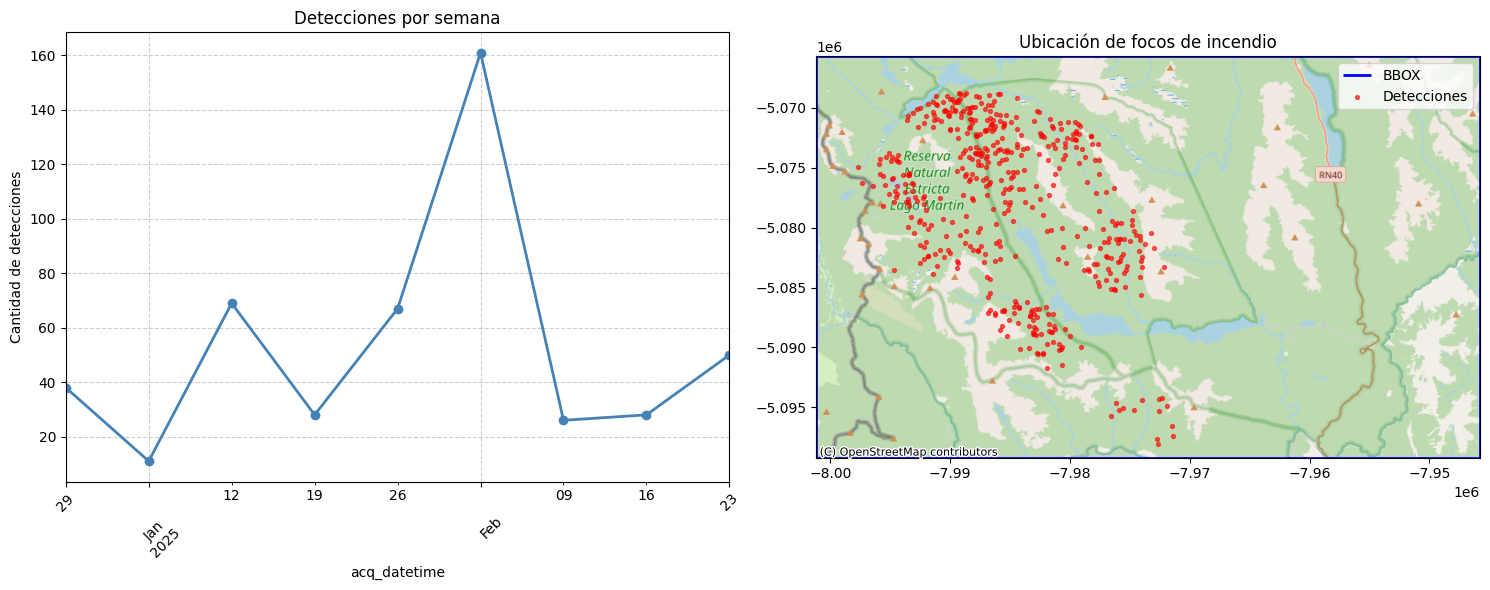

In [9]:
df_modis_sp = pd.read_csv(os.path.join(f'{cfg.DATA_RAW}/firms', 'firms_MODIS_SP_2024-12-01_2025-03-31.csv'))
df_modis_sp = firms.process_fire_data(df_modis_sp)

# Transformación de variables.
df_modis_sp['bright_t31'] = df_modis_sp['bright_t31'].apply(kelvin_to_celsius)

df_modis_sp = df_modis_sp[modis_cols]
df_modis_sp = df_modis_sp[modis_cols_reorder]
# df_modis_sp.head()
detection_map(df_modis_sp)


##### 3.1.2.2 - NOAA20 SP

In [ ]:
df_noaa20_sp = pd.read_csv(os.path.join(f'{cfg.DATA_RAW}/firms', 'firms_VIIRS_NOAA20_SP_2024-12-01_2025-03-31.csv'))
df_noaa20_sp = firms.process_fire_data(df_noaa20_sp)

# Transformación de variables.
df_noaa20_sp['bright_ti5'] = df_noaa20_sp['bright_ti5'].apply(kelvin_to_celsius)
df_noaa20_sp['bright_ti4'] = df_noaa20_sp['bright_ti4'].apply(kelvin_to_celsius)

df_noaa20_sp = df_noaa20_sp[viirs_cols]
df_noaa20_sp = df_noaa20_sp[viirs_cols_reorder]
# df_noaa20_sp.head()
detection_map(df_noaa20_sp)


##### 3.1.2.3 - SNPP SP

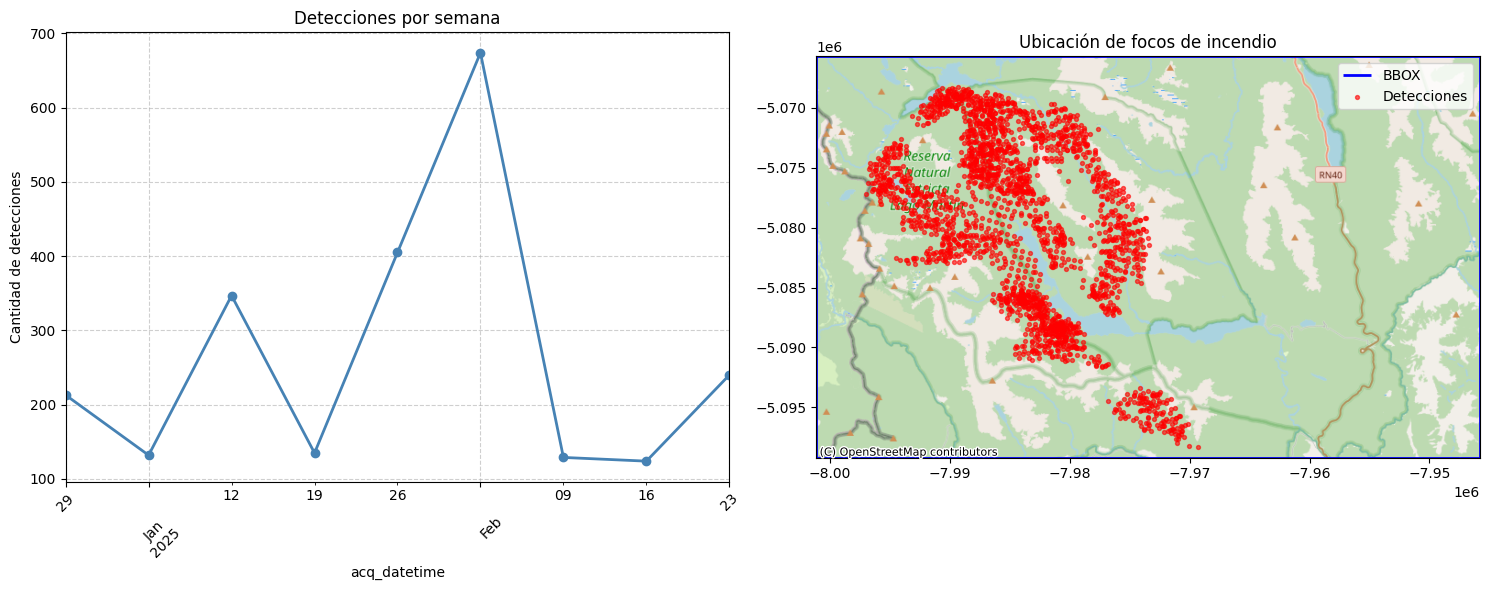

In [10]:
df_snpp_sp = pd.read_csv(os.path.join(f'{cfg.DATA_RAW}/firms', 'firms_VIIRS_SNPP_SP_2024-12-01_2025-03-31.csv'))
df_snpp_sp = firms.process_fire_data(df_snpp_sp)

# Transformación de variables.
df_snpp_sp['bright_ti5'] = df_snpp_sp['bright_ti5'].apply(kelvin_to_celsius)
df_snpp_sp['bright_ti4'] = df_snpp_sp['bright_ti4'].apply(kelvin_to_celsius)

df_snpp_sp = df_snpp_sp[viirs_cols]
df_snpp_sp = df_snpp_sp[viirs_cols_reorder]
# df_snpp_sp.head()
detection_map(df_snpp_sp)

In [ ]:
df_snpp_sp.head()


#### 3.1.3 - Información meteorologíca.


##### 3.1.3.1 - Copernicus ERA5 Levels

In [11]:
from copernicus_tools import CopernicusTools

Utilizando CopernicusTools se puede acceder a los datos provistos por el programa de observación terrestsre (Copernicus) de la Union Europea. Está información se obtendrá haciendo uso de la API provista por el CDS ([Climate Data Storage](https://cds.climate.copernicus.eu/)).

ERA5 proporciona estimaciones horarias de una gran cantidad de variables climáticas atmosféricas, terrestres y oceánicas. Los datos cubren la Tierra en una cuadrícula de 31 km y resuelven la atmósfera utilizando 137 niveles desde la superficie hasta una altura de 80 km. ERA5 incluye información sobre las incertidumbres de todas las variables con resoluciones espaciales y temporales reducidas. Utilice [este enlace](https://confluence.ecmwf.int/display/CKB/The+family+of+ERA5+datasets) para acceder a toda la documentación relevante.

In [ ]:
copernicus = CopernicusTools()
file = copernicus.get_meteorological_data('levels')
df_clima = file.to_dataframe().reset_index()

In [ ]:
df_clima.to_csv(f"{cfg.DATA_RAW}/copernicus/{cfg.START_DATE}_{cfg.END_DATE}.csv", index=False)

In [14]:
# Array de selección de columnas.
era5_cols = ['time', 'latitude', 'longitude', 't2m', 'u10', 'v10', 'sp', 'lai_hv', 'lai_lv']

In [15]:
df_era5 = pd.read_csv(os.path.join(f'{cfg.DATA_RAW}/copernicus', '2024-12-01_2025-03-31.csv'))
df_era5 = df_era5[era5_cols]
df_era5['t2m'] = df_era5['t2m'].apply(kelvin_to_celsius)
df_era5.head()

,time,latitude,longitude,t2m,u10,v10,sp,lai_hv,lai_lv
0,2024-12-01 00:00:00,-41.587,-71.876,7.70468,1.888102,-0.072591,89525.500,4.035121,2.867813
1,2024-12-01 00:00:00,-41.587,-71.625,6.97378,2.290331,-0.230725,87558.560,3.429728,2.428131
2,2024-12-01 06:00:00,-41.587,-71.876,5.06875,1.800133,-0.770239,89357.560,4.036283,2.867954
3,2024-12-01 06:00:00,-41.587,-71.625,3.77868,2.220085,-0.800481,87373.125,3.431776,2.428272
4,2024-12-01 12:00:00,-41.587,-71.876,3.18984,2.575717,0.326270,89494.470,4.037479,2.867992



### 3.2 - Cuestión clave


A estas alturas se ha conseguido la siguiente información:
- Focos de incendio en resolución espacial en: 1km, 0.375km
- Información meteorologica en: 25km

Problema: el nivel de datalle obtenido desde FIRMS no se coincide con el de Copernicus, para lograr un conjunto de datos donde la información de estas fuentes y aquellas a obtener se debe determinar la estrategía de unificación de datos.



1. Tomar como base el conjunto de datos meteorologícos, para cada foco de calor etiquetado por NASA, asignarlo a la celda de información ERA5. Sin embargo, el BBOX utilizado sólo devuelve una grilla del tipo 1x2 (25kms x 50kms) por ende quedarían dos zonas separadas dentro del área de estudio que compartirián caracteristicas meteorologicas similares y cantidad de focos de incendio con su respectiva información de FRP y brillo.

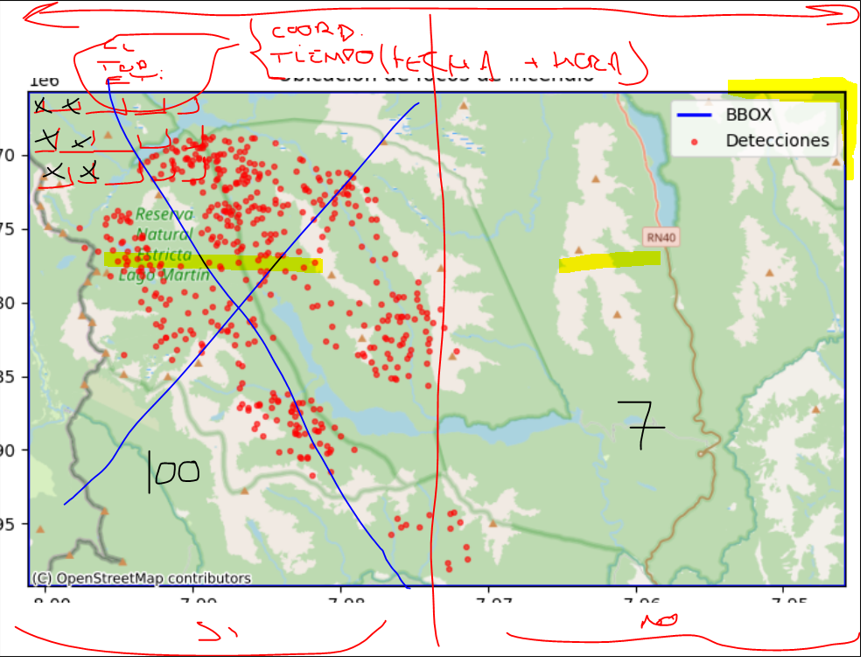

Esto implicaria perder el detalle que se obtiene desde VIIRS dado el traslado de sus datos de 375m a una escala de 25km, pero se aseguraria tener las variables climáticas que son el objeto de estudio para la predicción.


2. Llevar los datos meteorologícos a un grilla que se adapte a los focos de calor, está estrategía no mejoraría los datos de cara a la implementación de los modelos, dado que para cada foco, por ejemplo en la longitud oeste de la imagén de arriba, todos los focos tendrían las mismas condiciones climatologicas. Sin embargo, se podrían utilizar los métodos de interpolación y vecinos cercanos que expone Copernicus en su documentación.

